In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

In [6]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Loading & Preprocessing Data**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0 #normalizing pixel values
x_test = x_test.astype(np.float32)/255.0

4422102/4422102 [==============================] - 0s 0us/step


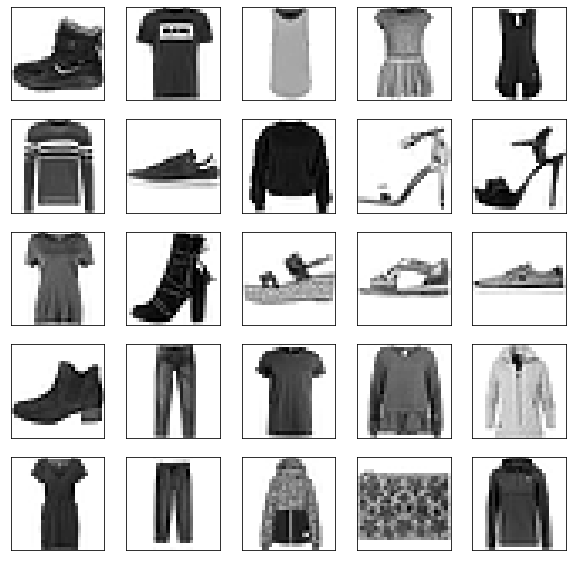

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

**Creating Batches of Dataset**

In [4]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

**Building Generator**

In [5]:
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*256, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh'),
])

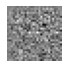

In [7]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
show(generated_image, 1)

**Building Discriminator**

In [10]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (1,1), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5013159]], shape=(1, 1), dtype=float32)


Compiling the Deep Convolution Generative Adversarial Network

In [33]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

**Defining Training Procedure**

In [34]:
seed = tf.random.normal(shape=[batch_size, 100])

In [36]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print(f"Epochs {epoch+1}/{epochs}")
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, num_features])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [35]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**Training DCGAN**

In [37]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [38]:
batch_size =32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

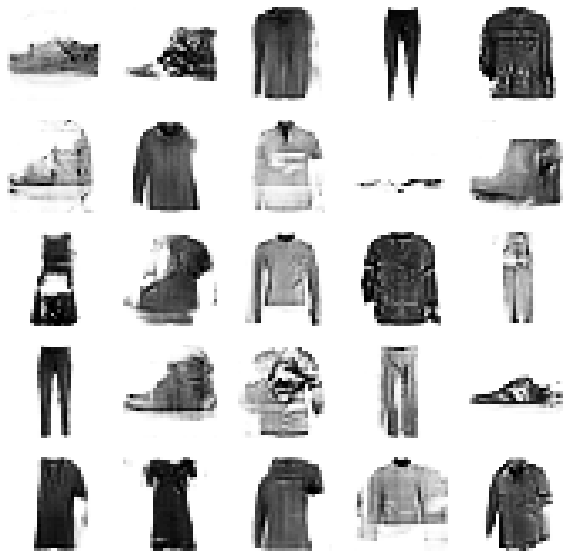

CPU times: user 7min 20s, sys: 24 s, total: 7min 44s
Wall time: 7min 12s


In [39]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=50)

**Generating Synthetic Images**

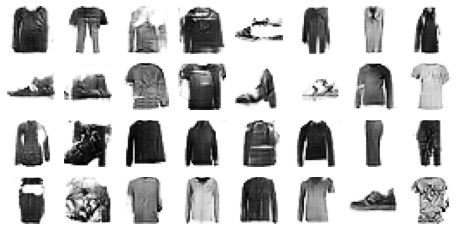

In [41]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

In [43]:
!pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00


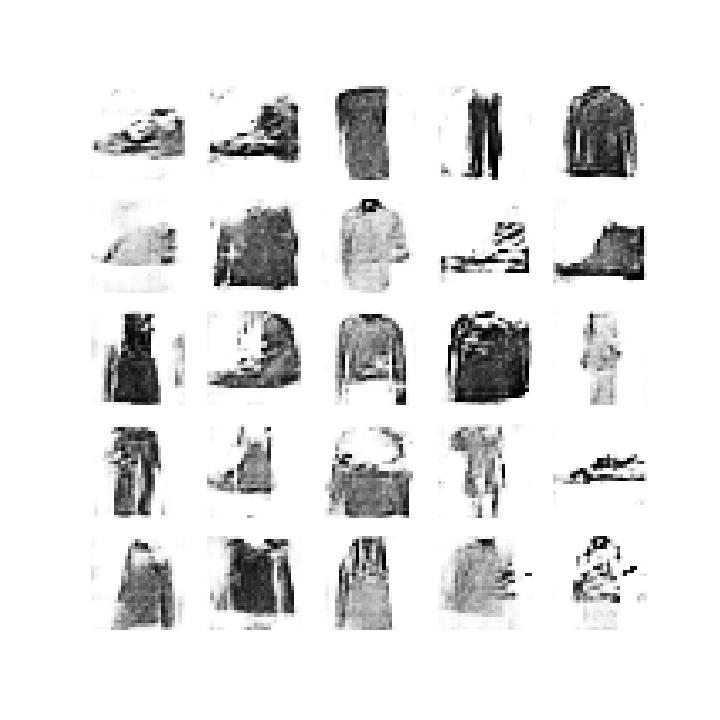

In [45]:
import imageio
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)